# 1. Setup
We start off by importing the Python libraries we need. We also import the `essays` dataset (`essays.csv`) that we can find in the `data` directory of our project. We also format the column names, so that they are easier to work with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
# import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

import nltk
# nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

essays_raw = pd.read_csv('data/essays.csv', engine='python');

def clean_colnames(df):
    df.columns = df.columns.str.replace("c|#", "").str.lower()
    return df
    
essays = clean_colnames(essays_raw.copy())
essays_raw.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


# 2. Inpect the data

Let's take a quick look at the structure of the `essays` dataset.

In [2]:
# Print the first few rows of the dataset
print(essays.head())

# Print the number of rows and colums
print("\nNumber of rows and columns: {} \n".format(essays.shape))

# Check if author ids are unique
if len(essays['authid']) == len(essays):
    print('All author ids are unique!')
else:
    print('Author ids are not unique!')
    
# Check if there are missing values in the dataset:
essays.isnull().sum()

            authid                                               text ext neu  \
0  1997_504851.txt  Well, right now I just woke up from a mid-day ...   n   y   
1  1997_605191.txt  Well, here we go with the stream of consciousn...   n   n   
2  1997_687252.txt  An open keyboard and buttons to push. The thin...   n   y   
3  1997_568848.txt  I can't believe it!  It's really happening!  M...   y   n   
4  1997_688160.txt  Well, here I go with the good old stream of co...   y   n   

  agr con opn  
0   y   n   y  
1   y   n   n  
2   n   y   y  
3   y   y   n  
4   y   n   y  

Number of rows and columns: (2467, 7) 

All author ids are unique!


authid    0
text      0
ext       0
neu       0
agr       0
con       0
opn       0
dtype: int64

We can see that we have a datasset containing 2467 essays from the same number of individual authors. We can also see that the dataset does not contain any missing values. Each essay is associated with an author id and 5 binary labels (one label per personality dimension):

* Extraversion (`ext`)
* Neuroticism (`neu`)
* Agreeableness (`agr`)
* Conscientiousness (`con`)
* Openess (`opn`)

Note that in psychological theory, the Big Five model actually considers all five traits as independent continious dimensions (and even defines sub dimensions - so-called facets - for each of them). However, for this machine learning task, the labels in our datasets represent just binary categories (e.g. a value of `y` in the `neu`-column indicates that the author of the given essay is neurotic).

Obviously, our goal is to predict the five binary labels for a given essay. In the other words, the task at hand is a binary multi label classification task. Before we create a train-test split and preprocess our data, let's explore it a little bit further. For example we can look at the distribution of labels for each dimension.

In [3]:
label_counts = pd.melt(essays.iloc[:, 2:7].apply(pd.Series.value_counts).reset_index().copy(),
                       id_vars = ['index'], var_name = 'dimension', value_name = 'count').rename(columns = {'index': 'label'})

label_counts

,label,dimension,count
0,n,ext,1191
1,y,ext,1276
2,n,neu,1234
3,y,neu,1233
4,n,agr,1157
5,y,agr,1310
6,n,con,1214
7,y,con,1253
8,n,opn,1196
9,y,opn,1271


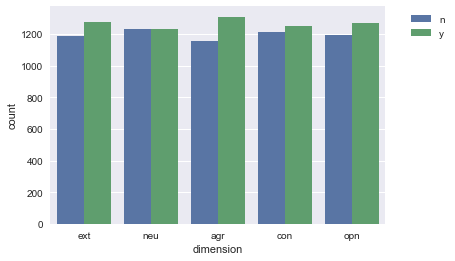

In [4]:
sns.barplot(x = "dimension", y = "count", hue = "label", data = label_counts)
plt.legend(loc = 'center right')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)

In the plot we can see that for each dimension the number of samples on the positive class (`y`) is roughly equal to the number of samples of the negative class (`n`). In other words, our dataset is appears to be pretty balanced (at least, if you look at each dimension separatly) Let's also look at the counts of individual combinations of dimensions:

32

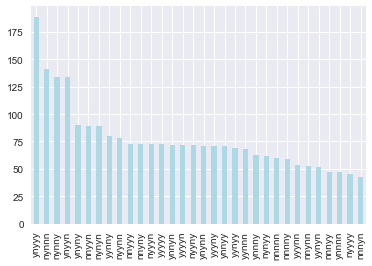

In [5]:
indiv_combs = (essays['ext'] + essays['neu'] + essays['agr'] + essays['con'] + essays['opn']). \
               value_counts()

indiv_combs.plot(kind = "bar", color = "lightblue")
len(indiv_combs)

From the plot above we can see that the individual combinations of dimensions are not equally frequent. Depending on how we attempt to solve our classification problem later on, this is something we want to keep in mind.

As another exploration step, let's take a look at the number of characters in the `text`-column:

AxesSubplot(0.125,0.125;0.775x0.755)


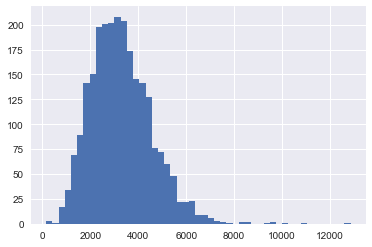

In [6]:
char_counts = essays.text.str.len()

print(char_counts.hist(bins = int(np.sqrt(len(essays)))))

Most essays appear to be between 2000 and 4000 characters long. There appear to some outliers as well (e.g. at least one essay with more than 12000 characters). This is something we want to keep in mind for later, as well.

Also, we should look at some sample essays to see which kind of preprocessing we should to later on:

In [7]:
essays.text[0]

'Well, right now I just woke up from a mid-day nap. It\'s sort of weird, but ever since I moved to Texas, I have had problems concentrating on things. I remember starting my homework in  10th grade as soon as the clock struck 4 and not stopping until it was done. Of course it was easier, but I still did it. But when I moved here, the homework got a little more challenging and there was a lot more busy work, and so I decided not to spend hours doing it, and just getting by. But the thing was that I always paid attention in class and just plain out knew the stuff, and now that I look back, if I had really worked hard and stayed on track the last two years without getting  lazy, I would have been a genius, but hey, that\'s all good. It\'s too late to correct the past, but I don\'t really know how to stay focused n the future. The one thing I know is that when  people say that b/c they live on campus they can\'t concentrate, it\'s b. s. For me it would be easier there, but alas, I\'m livin

The text looks pretty messy: For example, there are a lot of special characters and abbreviations. This is not optimal if you want to feed the text to a model.

# 3. Preprocessing

In this part, we will create classes that allow us clean our dataset. The goal is to have a nice and clean dataset that we can feed into a machine learning model.

Note that we define a class for each preprocessing step, so that we can build a pipeline that combines all steps later on. We implement these classes as *transformer classes* to be able to feed them into pipelines. While `sklearn`comes with a lot of useful *transformer classes* already, we implement most classes we need by hand to get some practice.

We also test each class on a copy of the dataset to make sure that the classes work as expected.

## 3.1 Define preprocessing functions
First, a class that cleans the column names of the raw data.

In [8]:
class ColNameCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X.columns = X.columns.str.replace("c|#", "").str.lower()
        return X

cleaner = ColNameCleaner()
cleaner.transform(essays_raw.copy()).head()

,authid,text,ext,neu,agr,con,opn
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


Next, we implement a class that drops the `#AUTHID` / `authid` column because we actually do not need it for the classification task.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = X.drop(columns = self.column)
        return X
    
dropper = ColDropper(column = "#AUTHID")
dropper.transform(essays_raw.copy()).head()

,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,I can't believe it! It's really happening! M...,y,n,y,y,n
4,"Well, here I go with the good old stream of co...",y,n,y,n,y


We also implement a class that converts the `y` labels to 1s on the `n` labels to 0s for each personality dimension. We do this because some algorithms can not string labels. Also using a boolean data type is more computionally efficient. Note that in order to use this class the column names need to be cleaned up already.

In [10]:
class LabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['ext'], X['neu'], X['agr'], X['con'], X['opn'] = [[True if x == 'y' else False for x in col] \
                                                                                         for col in [X['ext'],
                                                                                                     X['neu'],
                                                                                                     X['agr'],
                                                                                                     X['con'], 
                                                                                                     X['opn']]]
        return X
    
lbl_trnsfr = LabelTransformer()
lbl_trnsfr.transform(essays.copy()).head()

,authid,text,ext,neu,agr,con,opn
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",False,True,True,False,True
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",False,False,True,False,False
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,False,True,False,True,True
3,1997_568848.txt,I can't believe it! It's really happening! M...,True,False,True,True,False
4,1997_688160.txt,"Well, here I go with the good old stream of co...",True,False,True,False,True


As we can see from the output above, the string labels got turned into boolean values (True, False).

Next, we create a function to clean the `TEXT` /`text` column. This function turns all letters to lower case and removes some abbreviations that are common in the english language. It also removes special characters and multiple consecutive spaces.

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"i’m", "i am ", text)
    text = re.sub('b/c', 'because', text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"’ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

clean_text(essays_raw.TEXT[0])

'well right now i just woke up from a mid day nap it sort of weird but ever since i moved to texas i have had problems concentrating on things i remember starting my homework in 10th grade as soon as the clock struck 4 and not stopping until it was done of course it was easier but i still did it but when i moved here the homework got a little more challenging and there was a lot more busy work and so i decided not to spend hours doing it and just getting by but the thing was that i always paid attention in class and just plain out knew the stuff and now that i look back if i had really worked hard and stayed on track the last two years without getting lazy i would have been a genius but hey that all good it too late to correct the past but i do not really know how to stay focused n the future the one thing i know is that when people say that because they live on campus they can not concentrate it b s for me it would be easier there but alas i am living at home under the watchful eye of

When we take a look at our sample essay now, it looks pretty good. Note that to make things simpler a string like `it's` is striped down to just `it`. We chose to do so because `is` is a typical stopword that we'll remove anyway.

Now, we implement a class `TextCleaner` that applies the `clean_text` function to every row in the  `TEXT` / `text` column.

In [12]:
# Pipeline test
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, txt_col):
        self.txt_col = txt_col
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X[self.txt_col] = X[self.txt_col].apply(clean_text)
        return X

cleaner = TextCleaner('TEXT')
cleaner.transform(essays_raw.copy()).head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,well right now i just woke up from a mid day n...,n,y,y,n,y
1,1997_605191.txt,well here we go with the stream of consciousne...,n,n,y,n,n
2,1997_687252.txt,an open keyboard and buttons to push the thing...,n,y,n,y,y
3,1997_568848.txt,i can not believe it it really happening my pu...,y,n,y,y,n
4,1997_688160.txt,well here i go with the good old stream of con...,y,n,y,n,y


Looks alright. Our preprocessing classes seem to work fine. It's time to build a pipeline that combines the different preprocessing steps.

## 3.3. Build and apply cleaning pipeline

We create a pipeline that contains all preprocessing steps we defined early. We can pass the raw data to the apply to create a clean data set that is (almost) ready to be fed to an machine learning algorithm.

Note that we'll create another pipeline later on (after we create a train-test split). This pipeline uses the class `TfidfVectorizer` from `sklearn` to tokenize the text data and compute tf-idf statistics. This class can also be used to remove stop words from text input. Stop words are words that occur very frequently and thus do not contain much information about the specific content of a text. The second pipeline also contains a modelling step (i.e. fitting some classifier).

This seperation into two pipelines is neccessary because `TfidfVectorizer` alters the shape of the input data. Thus, in order to feed datasets of different sizes (i.e. the test set) into a trained model, vectorization should go hand in hand with the modelling step.

In [13]:
# New pipeline

clean_pipeline = Pipeline([('colclean', ColNameCleaner()),
                           ('idcoldrop', ColDropper("authid")),
                           ('lbltransf', LabelTransformer()),
                           ('txtclean', TextCleaner('text'))])

essays_clean = clean_pipeline.fit_transform(essays_raw.copy())
essays_clean.head()

,text,ext,neu,agr,con,opn
0,well right now i just woke up from a mid day n...,False,True,True,False,True
1,well here we go with the stream of consciousne...,False,False,True,False,False
2,an open keyboard and buttons to push the thing...,False,True,False,True,True
3,i can not believe it it really happening my pu...,True,False,True,True,False
4,well here i go with the good old stream of con...,True,False,True,False,True


## 3.2 Create a training set and a testing set

We create a train test split from the raw data.

In [14]:
train, test = train_test_split(essays_clean, random_state = 1, test_size = 0.3, shuffle = True)

X_train = train['text'].copy()
Y_train = train.copy().drop('text', axis = 1)

X_test = test['text'].copy()
Y_test = test.copy().drop('text', axis = 1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1726,)
(741,)
(1726, 5)
(741, 5)


# 4. Explore models

In the next step we try out some common machine learning algorithms on the preprocessed training set and see which algorithms appear to be promising. We also choose the approach to fit a separate model for each label as done by previous work (e.g. Majumber et al., 2016). We write a function that computes tf-idf statistics for the `text` column and fits seperate model for each personality dimension. It also evalutes the model on the training set using the `accuracy` metric. 

In [15]:
def multi_label_clf(classifier, categories = ['ext', 'neu', 'agr', 'con', 'opn']):
    
    model_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words = stop_words)),
                               ('clf', classifier)])
    
    print('Accuracy using {}'.format(classifier))
    
    for category in categories:
        model_pipeline.fit(X_train, Y_train[category])
        preds = model_pipeline.predict(X_train)
        print('Dimension {}: {}'.format(category, accuracy_score(Y_train[category], preds)))
    
    print('\n')

Now, we can easily apply this function to some algorithms we are interested in. By the way, as an alternative approach we could have used `sklearn`'s `MultiOuputClassifier` class to handle multi label classification (some algorithms support it by default, e.g. `KNeighborsClassifier`).

Exmaple of training a classifier using the `MultiOutputClassifier`class:

`forest_clf = MultiOutputClassifier(RandomForestClassifier(n_estimators = 20))`

`forest_clf.fit(X_train_prepared, y_train_prepared)`

In [16]:
classifiers = [MultinomialNB(fit_prior = True, class_prior = None),
               RandomForestClassifier(n_estimators = 50, random_state = 42),
               LogisticRegression(solver = 'sag')]

nb_clf, forest_clf, log_clf = list((map(multi_label_clf, classifiers)))
print(nb_clf, forest_clf, log_clf)

Accuracy using MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Dimension ext: 0.8030127462340672
Dimension neu: 0.9391657010428737
Dimension agr: 0.5909617612977984
Dimension con: 0.8962920046349943
Dimension opn: 0.9235225955967555


Accuracy using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Dimension ext: 1.0
Dimension neu: 1.0
Dimension agr: 1.0
Dimension con: 1.0
Dimension opn: 1.0


Accuracy using LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,


# 5. Model tuning
The RandomForrestClassifer seems to do very well (perfect accuracy for all dimensions). The logistic regression perform good as well. So, we further explore these two model types.

The perfect accuracy of the random forest model (accuracy scores of 1.0 for all five dimensions) indicates that the random forrest algorithm overfits the data. We don't want to touch our test set yet since we still need to fine-tune our model. To get a more realistic estimate on how the algorithm performs on new data we can use cross-validation.

(Although the dataset is quite balanced we might want to take a look at metrics other than accuracy, as well - for example precision, recall and the F1-score.)

In [17]:
def multi_label_clf_cv(classifier, categories = ['ext', 'neu', 'agr', 'con', 'opn']):
    
    model_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words = stop_words)),
                               ('clf', classifier)])
    
    print('Accuracy using {}'.format(classifier))
    
    for category in categories:
        model_pipeline.fit(X_train, Y_train[category])
        scores = cross_val_score(model_pipeline, X_train, Y_train[category], scoring = "accuracy", cv = 3)
        print(scores)
    print('\n')

In [18]:
multi_label_clf_cv(RandomForestClassifier(n_estimators = 50, random_state = 42))
multi_label_clf_cv(LogisticRegression(solver = 'sag'))

Accuracy using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
[0.57465278 0.55478261 0.53913043]
[0.54340278 0.54513889 0.54355401]
[0.515625   0.5373913  0.57391304]
[0.55381944 0.51130435 0.5426087 ]
[0.59201389 0.59722222 0.61672474]


Accuracy using LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)
[0.56076389 0.56695652 0.59130435]
[0.54513889 0.51736111 0.57839721]
[0.54513889 0.54434783 0.54608696]
[0.609375   0.53913043

Oof! When using cross validation the algorithms do not do as well as expected. The accuracy for most dimensions is barely above chance level (50%). Now, the logistic regression seems to do a little bit better compared the random forest. One thing we can do to optimize our model is tune its hyperparameters using grid search or randomized search.

From now on we'll concentrate on the `LogisticRegression` classifiers since it seems to perform better on data it has not seen before.

Remember that we actually fit one model per personality dimension. We will do a grid search for each model to find good hyperparameters. We'll only focus on some of the possbile hyperparameters.

In [19]:
def log_reg_search(category):
    log_reg_pipe = Pipeline([("tfidf",  TfidfVectorizer(stop_words = stop_words)),
                         ('clf', LogisticRegression())])

    param_grid = {}
    param_grid["clf__C"] = np.logspace(-3, 3, 7)
    param_grid["clf__solver"] = ["liblinear", "sag"]

    grid_search = GridSearchCV(log_reg_pipe, param_grid, cv = 3,
                              scoring = 'accuracy')

    grid_search.fit(X_train, Y_train[category])
    
    return grid_search.best_estimator_

In [20]:
# Running this cell might take a few minutes
categories = ['ext', 'neu', 'agr', 'con', 'opn']

best_ext_model, best_neu_model, best_agr_model,best_con_model, best_opn_model = list(map(log_reg_search, categories))

In [31]:
# Example of a model validation using cross validation
best_ext_model.fit(X_train, Y_train['ext'])
scores = cross_val_score(best_ext_model, X_train, Y_train['ext'], scoring = "accuracy", cv = 3)
print(scores)

[0.56076389 0.56695652 0.59130435]


In [27]:
# Example of a model validation using cross validation
best_neu_model.fit(X_train, Y_train['neu'])
scores = cross_val_score(best_ext_model, X_train, Y_train['neu'], scoring = "accuracy", cv = 3)
print(scores)

[0.546875   0.51736111 0.57665505]


In [30]:
# Example of a model validation using cross validation
best_agr_model.fit(X_train, Y_train['agr'])
scores = cross_val_score(best_ext_model, X_train, Y_train['agr'], scoring = "accuracy", cv = 3)
print(scores)

[0.54513889 0.54434783 0.54956522]


In [29]:
# Example of a model validation using cross validation
best_con_model.fit(X_train, Y_train['con'])
scores = cross_val_score(best_ext_model, X_train, Y_train['con'], scoring = "accuracy", cv = 3)
print(scores)

[0.60590278 0.5426087  0.53391304]


In [22]:
# Example of a model validation using cross validation
best_opn_model.fit(X_train, Y_train['opn'])
scores = cross_val_score(best_ext_model, X_train, Y_train['opn'], scoring = "accuracy", cv = 3)
print(scores)

[0.60416667 0.65104167 0.63763066]


Evaluate models using the test set:

In [23]:
def test_accuracy(category, model):
    preds = model.predict(X_test)
    preds = model.predict(X_test)
    return accuracy_score(Y_test[category], preds)

In [24]:
print(test_accuracy('ext', best_ext_model),
      test_accuracy('neu', best_neu_model),
      test_accuracy('agr', best_agr_model),
      test_accuracy('con', best_con_model),
      test_accuracy('opn', best_opn_model))

0.553306342780027 0.5681511470985156 0.5425101214574899 0.5465587044534413 0.6140350877192983


Well, at least all accuracy scores are above chance level. Personality detection from text is a hard. Even in the work of Majumber et al. (2016) (which compared a lot different deep learning and shallow machine learning models) 4 out of 5 models (per personality dimension) reached a mean accuracy of below 0.6.

Next steps:
* Code / Struktur überarbeiten
* Weitere mögliche Modelle explorieren, Grid Search optimieren
* Mögliche Verbesserungen recherchieren
* Das Modell auf andere Texte anwenden (z.B. Text von bekannten Persönlichkeiten - Donald Trump etc.)
* word2vec und xgboost ausprobieren